# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.115420,False,1.875527
1,-2.528765,False,-4.130106
2,1.151224,True,8.467581
3,-0.495840,False,-0.598746
4,0.159693,False,-0.699313
...,...,...,...
995,1.468222,True,8.460250
996,1.045305,True,5.128491
997,-0.519200,False,-1.552764
998,-0.205118,False,-2.097409


<Axes: xlabel='v0'>

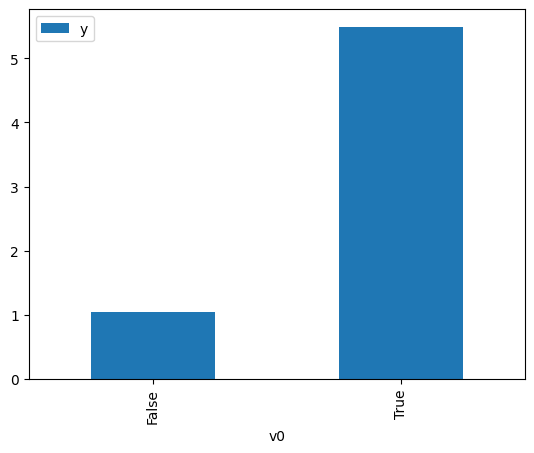

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

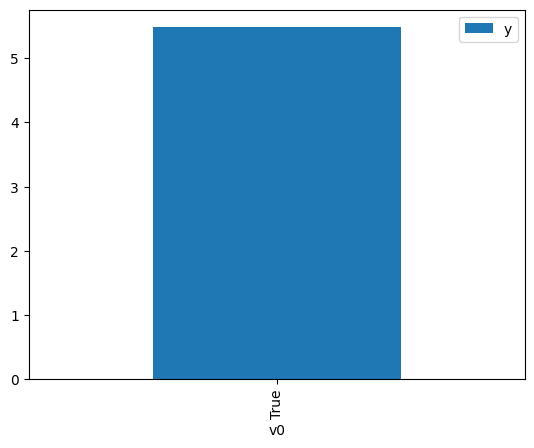

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.613650,False,0.469236,0.254895,3.923180
1,0.144387,False,0.955309,0.464054,2.154924
2,2.113959,False,5.948964,0.017265,57.921472
3,-0.340227,False,-1.321590,0.693170,1.442649
4,-0.120443,False,1.290028,0.593884,1.683831
...,...,...,...,...,...
995,0.256167,False,0.558967,0.409692,2.440859
996,-0.553712,False,-1.910783,0.775120,1.290123
997,0.288537,False,2.406334,0.394294,2.536179
998,-0.627053,False,-0.281023,0.799406,1.250928


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.828873,True,8.363299,0.970041,1.030884
1,2.275568,True,9.867628,0.987401,1.012759
2,0.309673,True,5.730490,0.615650,1.624300
3,0.317178,True,6.175273,0.619158,1.615097
4,-1.883029,True,0.040604,0.020471,48.849963
...,...,...,...,...,...
995,0.105814,True,3.407295,0.516919,1.934539
996,0.204713,True,5.931558,0.565476,1.768422
997,1.014560,True,5.912940,0.866000,1.154735
998,0.966197,True,7.166953,0.854500,1.170276


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.620e+04
Date:                Fri, 21 Jul 2023   Prob (F-statistic):                        0.00
Time:                        14:19:14   Log-Likelihood:                         -1406.6
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2827.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2030      0.038     58.472      0.000       2.129       2.277
x2             5.0368      0.052     96.847      0.000       4.935       5.139
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.186
Skew:                           0.033   Prob(JB):                        0.911
Kurtosis:                       2.987   Cond. No.                         2.24
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""